## Importing libraries ##

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.special import factorial
from landaupy import landau
from scipy.special import factorial
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import array
from collections import Counter
import daw_readout
from matplotlib.colors import LogNorm
from tqdm import trange
from tqdm import tqdm
import time  
import os 

np.set_printoptions(suppress=True) # to make tiny values appear as zero
np.set_printoptions(precision=4)   # number of digits in floats (or longfloats)
#np.set_printoptions(formatter={'float_kind':"{:.2f}"})
#np.set_printoptions()

%matplotlib inline

# Set formats
DARK=False
if(DARK==False):
    form='.k'
    plt.style.use(['default']) 
    fontcolor='k'
else:
    form='.w'
    plt.style.use(['dark_background'])
    fontcolor='w'


SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {
    'font.family': 'serif',
    'font.size' : 16, 'axes.titlesize' : 16, 'axes.labelsize' : 16, 'axes.linewidth' : 1,
    # ticks
    'xtick.labelsize' : 16, 'ytick.labelsize' : 16, 'xtick.major.size' : 8, 'xtick.minor.size' : 4,
    'ytick.major.size' : 8, 'ytick.minor.size' : 4, 'xtick.major.width' : 1, 'xtick.minor.width' : 1,
    'ytick.major.width' : 1, 'ytick.minor.width' : 1, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 4, 'lines.markeredgewidth' : 1, 'errorbar.capsize' : 5, 'lines.linewidth' : 1.5,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 16,
    'axes.labelsize': 16, 'axes.titlesize':20, 'xtick.labelsize':16, 'ytick.labelsize':16,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':8,
    # ticks
    'xtick.major.pad': 7,   'xtick.minor.pad': 7,   
    'ytick.major.pad': 4, 'ytick.minor.pad': 4,
}
plt.rcParams.update(params)

### Load, process, examine and filter data

In [82]:
Date = 20240924 # YYYYMMDD
V = 1.300 # V
offset = 900 # mV
T = 100 # ns
PDiv = 9 # dB

name = "lv2415_anode_lv2414_dual_20240924_LED_1.300V_900mv_100ns_attenuator_9DB_400_ratio_run0"

calbl = 10 ### Length used to calculate baseline
calstart = 95 ### Index started to calculate area
callen= 85 ### Length used to calculate area

In [83]:
path = "/mnt/data/PMT/R8520_406/"   ##### file path

filesnum = 1 ### number of files

hdf5_filename = path + name + ".h5"
feather_filename = path + name + ".feather"
filename = {}
filepath = {}
dataload = {}
for i in range(filesnum):
    filename[i] = name + "_raw_b0_seg" + str(i) +".bin"
    filepath[i] = path + filename[i]
    dataload[i] = daw_readout.DAWDemoWaveParser(filepath[i])

#name_3 = 'run_gamma_$(date_raw_b0_seg0.bin'

### Background data
#data0 = daw_readout.DAWDemoWaveParser([path+name[0]])#### background data

data = []

for num in range(filesnum):
# Process the waveforms and store the data in lists
    i = 0
    for wave in tqdm(dataload[num]):
        baseline2 = np.sum(wave.Waveform[:calbl]) / calbl
        area = (baseline2 * callen - np.sum(wave.Waveform[calstart : calstart+callen]))
        height = (baseline2 - np.min(wave.Waveform[calstart : calstart+callen]))
        data.append({
            'Files': num,   ####file name/number
            'EventID': i,   ####index in file
            'Channel': wave.Channel, #### PMT Channel
            'Timestamp': wave.Timestamp, 
            'Baseline': wave.Baseline,
            'Baseline2': baseline2,
            'Height': height,
            'Area': area,
            'AtH':area/height,
            'Waveform':wave.Waveform
            })
        i += 1

# Convert lists to pandas DataFrames
df = pd.DataFrame(data)

# Print the total number of events for each channel
print("CH0 Total Events:",len(df.EventID[df.Channel==0]))
print("CH1 Total Events:",len(df.EventID[df.Channel==1]))

ch1_area_0 = []
ch0_area_0 = []
ch2_area_0 = []

ch0_area = []
ch1_area = []
ch2_area = []

area_ratio = []

for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area.append(df.Area[i]/96.99)
    elif df.Channel[i] == 0:
        ch0_area.append(df.Area[i]/77.79)
    elif df.Channel[i] == 2:
        ch2_area.append(-df.Area[i]/77.79)

"""
for i in tqdm(range(0,len(df.Area))):
    if df.Channel[i] == 1:
        ch1_area_0.append(df.Area[i])
    elif df.Channel[i] == 0:
        ch0_area_0.append(df.Area[i])

for i in tqdm(range(0,len(ch0_area_0))):
    if ch1_area_0[i] > 60:
        ch0_area.append(ch0_area_0[i])
        ch1_area.append(ch1_area_0[i])
"""

for i in tqdm(range(0,len(ch0_area))):
    if ch1_area[i] != 0:
        area_ratio.append(ch0_area[i]/ch1_area[i])
    else:
        area_ratio.append(0)

0it [00:00, ?it/s]/tmp/ipykernel_3047045/404505943.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  'AtH':area/height,
386607it [00:03, 108053.52it/s]


CH0 Total Events: 128869
CH1 Total Events: 128869


100%|██████████| 128869/128869 [00:00<00:00, 4069627.85it/s]


In [84]:
# Area ratio
with open('linear.txt', 'a') as f:
    print(V,T,round(np.mean(ch0_area),2),round(np.std(ch0_area),2),round(np.mean(ch1_area),2),round(np.std(ch1_area),2),
          PDiv,Date,round(np.mean(ch2_area),2),round(np.std(ch2_area),2), file=f)

In [75]:
df[:]

,Files,EventID,Channel,Timestamp,Baseline,Baseline2,Height,Area,AtH,Waveform
0,0,0,0,180472,15170,15170.2,13197.2,236437.0,17.915694,"[15173, 15173, 15170, 15168, 15172, 15168, 151..."
1,0,1,1,180472,15321,15320.6,2374.6,26419.0,11.125663,"[15316, 15324, 15318, 15322, 15320, 15320, 153..."
2,0,2,2,180472,8113,8113.7,7.7,-18351.5,-2383.311688,"[8113, 8114, 8114, 8113, 8114, 8112, 8114, 811..."
3,0,3,0,430468,15169,15168.2,13217.2,235790.0,17.839633,"[15171, 15168, 15164, 15172, 15171, 15165, 151..."
4,0,4,1,430468,15321,15323.7,2132.7,27172.5,12.740892,"[15323, 15324, 15326, 15324, 15326, 15325, 153..."
...,...,...,...,...,...,...,...,...,...,...
277168,0,277168,1,23097268036,15323,15322.5,2910.5,30809.5,10.585638,"[15322, 15322, 15320, 15322, 15327, 15320, 153..."
277169,0,277169,2,23097268036,8113,8112.4,4.4,-18795.0,-4271.590909,"[8112, 8112, 8114, 8116, 8111, 8107, 8113, 811..."
277170,0,277170,0,23097518036,15169,15167.4,13328.4,235082.0,17.637676,"[15169, 15165, 15165, 15170, 15168, 15163, 151..."
277171,0,277171,1,23097518036,15323,15324.1,2685.1,28519.5,10.621392,"[15322, 15326, 15325, 15323, 15323, 15325, 153..."


100%|██████████| 200/200 [00:00<00:00, 2929.75it/s]
/tmp/ipykernel_1657990/1620404276.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


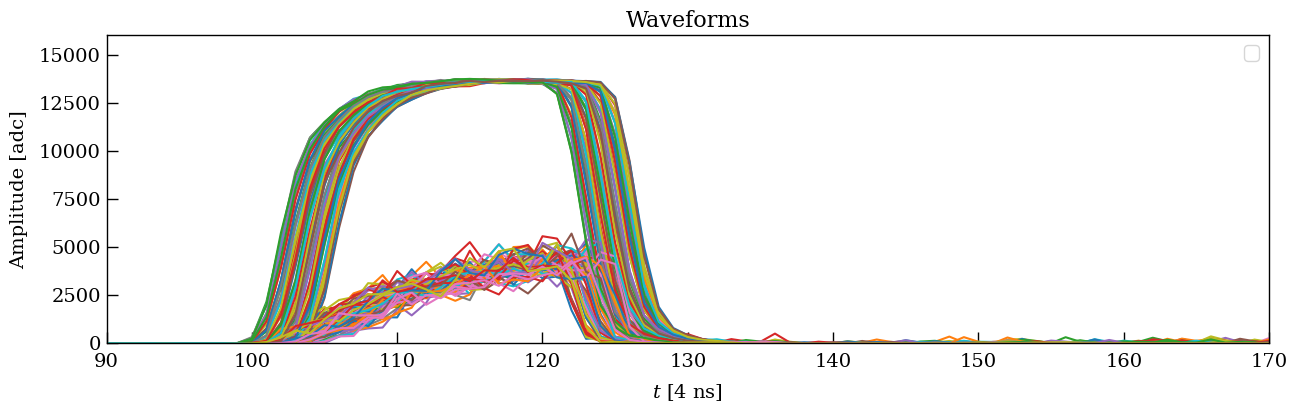

In [102]:
plt.figure(figsize=(15,4))
plt.title('Waveforms')
plt.xlabel('$t$ [4 ns]')
plt.ylabel('Amplitude [adc]')
plt.xlim(90,170)
plt.ylim(0,16000)
for i in tqdm(range (0,200)):
    #plt.step(np.linspace(0,150,150),df.Baseline[i]-df.Waveform[i])
    plt.plot(df.Baseline[i]-df.Waveform[i])
plt.legend()
plt.show()

### Scatter plots

In [ ]:
bin1 = np.linspace(np.min(ch1_area), np.max(ch1_area),200) ###x Height
bin2 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bins = [bin1,bin2]

H, xedges, yedges = np.histogram2d(ch1_area,ch0_area,bins)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

# definitions for the axes
left, width = 1, 1
bottom, height = 1, 1
bottom_h = left_h = left + width + 0.025

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
fig = plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axScatter.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
axScatter.set_xlim(min(ch1_area),max(ch1_area))
axScatter.set_ylim(min(ch0_area),max(ch0_area))
axScatter.set_xlabel('CH1 area [PE]')
axScatter.set_ylabel('CH0 area [PE]')

axHistx.hist(ch1_area,bins=200,histtype='step',linewidth=3,color='darkblue')
axHistx.set_xlim(min(ch1_area),max(ch1_area))
axHistx.set_xticks([])
axHistx.set_ylabel('Counts')

axHisty.hist(ch0_area,bins=200,orientation='horizontal',histtype='step',linewidth=3,color='darkblue')
axHisty.set_ylim(min(ch0_area),max(ch0_area))
axHisty.set_yticks([])
axHisty.set_xlabel('Counts')

plt.suptitle('Pulse area with and without polariser, '+str(V)+' V, '+str(T)+' ns',x=1.55,y=2.275)

plt.savefig('./img/Pulse area with and without polariser, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

In [ ]:
bin3 = np.linspace(0,200,200) ###x Height
bin4 = np.linspace(np.min(ch0_area), np.max(ch0_area), 200)###y Area
bin2s = [bin4,bin3]

filtered_area_ratio = []
filtered_ch0_area = []
for i in tqdm(range(0,len(area_ratio))):
    if area_ratio[i]!=0:
        filtered_area_ratio.append(area_ratio[i])
        filtered_ch0_area.append(ch0_area[i])

area_average = np.average(filtered_area_ratio)

H, xedges, yedges = np.histogram2d(filtered_ch0_area,filtered_area_ratio,bin2s)
H = np.rot90(H) 
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)\

H_sum = []

for i in range(0,len(H)):
    H_sum.append(np.sum(H[i][:]))

area_frequent = np.where(H_sum == np.max(H_sum))[0][0]

# definitions for the axes
left, width = 1, 1
bottom, height = 1, 1
bottom_h = left_h = left + width + 0.025

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axScatter.pcolormesh(xedges,yedges,Hmasked,norm=LogNorm())
axScatter.set_xlabel('CH0 area [PE]')
axScatter.set_ylabel('Area ratio CH0/CH1')
axScatter.set_xlim(min(ch0_area),max(ch0_area))
axScatter.hlines(y=area_average,xmin=np.min(ch0_area),xmax=np.max(ch0_area),
           linestyle='--',color='orange',
           label='average area ratio = '+str(round(area_average,1)))
axScatter.hlines(y=area_frequent,xmin=np.min(ch0_area),xmax=np.max(ch0_area),
           linestyle='--',color='red',
           label='most frequent area ratio = '+str(area_frequent))
axScatter.legend()

axHistx.hist(filtered_ch0_area,bins=200,histtype='step',linewidth=3,color='darkblue')
axHistx.set_xlim(min(ch0_area),max(ch0_area))
axHistx.set_xticks([])
axHistx.set_ylabel('Counts')

axHisty.hist(area_ratio,bins=200,range=(0,200),orientation='horizontal',histtype='step',linewidth=3,color='darkblue')
axHisty.set_ylim(0,200)
axHisty.set_yticks([])
axHisty.set_xlabel('Counts')

plt.suptitle('Pulse area ratio against area without polariser, '+str(V)+' V, '+str(T)+' ns',x=1.55,y=2.275)

plt.savefig('./img/Pulse area ratio with and without polariser, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

### CH1 Histogram - P

In [ ]:
# Use numpy.hist() function to calculate histogram data
ch1_hist,ch1_bin_edges = np.histogram(ch1_area,bins=200,range=(0,max(ch1_area)))
ch1_g = ch1_hist
ch1_x = (ch1_bin_edges[:-1] + ch1_bin_edges[1:])/2

# Define non-normalised Gaussian function
def poisson_fit(x,A,mu,x_0):
  g = A * np.exp(-mu)*np.power(mu, (x-x_0))/factorial(x-x_0)
  return g

# Curve fit the histgram data using curve_fit()
ch1_popt,ch1_pcov = curve_fit(poisson_fit,ch1_x,ch1_g,p0=(1E5,20,0))
ch1_perr = np.sqrt(np.diag(ch1_pcov))

# Report the parameters
print('A =', round(ch1_popt[0],3), '+/-', round(ch1_perr[0],3))
print('mu =', round(ch1_popt[1],3), '+/-', round(ch1_perr[1],3))
print('x_0 =', round(ch1_popt[2],3), '+/-', round(ch1_perr[2],3))

# prepare for the fitted curve
ch1_u = np.arange(0,max(ch1_area),0.1)
ch1_v = poisson_fit(ch1_u,ch1_popt[0],ch1_popt[1],ch1_popt[2])

plt.figure(figsize=(16,9))
plt.title('Histogram of CH1 area, '+str(V)+' V, '+str(T)+'ns, '+str(PDiv)+'dB')
plt.xlabel('CH1 area [PE]')
plt.ylabel('Counts')
plt.hist(ch1_area,bins=200,color='silver',label='CH0 area')
plt.plot(ch1_u,ch1_v,color='darkblue',linewidth=3,
         label='Fitted curve, $\mu$ = '+str(round(ch1_popt[1],3))+', $x_0$ = '+str(round(ch1_popt[2],3)))
plt.legend()
plt.savefig('./img/Histogram of CH1 area, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

### CH1 histogram - G

In [ ]:
# Use numpy.hist() function to calculate histogram data
ch1_hist,ch1_bin_edges = np.histogram(ch1_area,bins=200)
ch1_g = ch1_hist
ch1_x = (ch1_bin_edges[:-1] + ch1_bin_edges[1:])/2

# Define non-normalised Gaussian function
def gaussian(x,A,mu,sigma):
  g = A * np.exp(-(x-mu)**2 / (2*sigma**2))
  return g

# Curve fit the histgram data using curve_fit()
ch1_popt,ch1_pcov = curve_fit(gaussian,ch1_x,ch1_g,p0=(1000,(min(ch1_area)+max(ch1_area))/2,50))
ch1_perr = np.sqrt(np.diag(ch1_pcov))

# Report the parameters
print('A =', round(ch1_popt[0],3), '+/-', round(ch1_perr[0],3))
print('mu =', round(ch1_popt[1],3), '+/-', round(ch1_perr[1],3))
print('sigma =', round(ch1_popt[2],3), '+/-', round(ch1_perr[2],3))

# prepare for the fitted curve
ch1_u = np.arange(min(ch1_area),max(ch1_area),0.1)
ch1_v = round(ch1_popt[0],3) * np.exp(-(ch1_u-round(ch1_popt[1],3))**2 / (2*round(ch1_popt[2],3)**2))

plt.figure(figsize=(16,9))
plt.title('Histogram of CH1 area, '+str(V)+' V, '+str(T)+'ns, '+str(PDiv)+'dB')
plt.xlabel('CH1 area [PE]')
plt.ylabel('Counts')
plt.hist(ch1_area,bins=200,color='silver',label='CH1 area')
plt.plot(ch1_u,ch1_v,color='darkblue',linewidth=3,
         label='Fitted curve, $\mu$ = '+str(round(ch1_popt[1],3))+', $\sigma$ = '+str(np.abs(round(ch1_popt[2],3))))
plt.legend()
plt.savefig('./img/Histogram of CH1 area, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

### CH2 Histogram - G

In [ ]:
# Use numpy.hist() function to calculate histogram data
ch2_hist,ch2_bin_edges = np.histogram(ch2_area,bins=200)
ch2_g = ch2_hist
ch2_x = (ch2_bin_edges[:-1] + ch2_bin_edges[1:])/2

# Define non-normalised Gaussian function
def gaussian(x,A,mu,sigma):
  g = A * np.exp(-(x-mu)**2 / (2*sigma**2))
  return g

# Curve fit the histgram data using curve_fit()
ch2_popt,ch2_pcov = curve_fit(gaussian,ch2_x,ch2_g,p0=(1000,(min(ch2_area)+max(ch2_area))/2,50))
ch2_perr = np.sqrt(np.diag(ch2_pcov))

# Report the parameters
print('A =', round(ch2_popt[0],3), '+/-', round(ch2_perr[0],3))
print('mu =', round(ch2_popt[1],3), '+/-', round(ch2_perr[1],3))
print('sigma =', round(ch2_popt[2],3), '+/-', round(ch2_perr[2],3))

# prepare for the fitted curve
ch2_u = np.arange(min(ch2_area),max(ch2_area),0.1)
ch2_v = round(ch2_popt[0],3) * np.exp(-(ch2_u-round(ch2_popt[1],3))**2 / (2*round(ch2_popt[2],3)**2))

plt.figure(figsize=(16,9))
plt.title('Histogram of CH2 area, '+str(V)+' V, '+str(T)+'ns, '+str(PDiv)+'dB')
plt.xlabel('CH2 area [PE]')
plt.ylabel('Counts')
plt.hist(ch2_area,bins=200,color='silver',label='CH2 area')
plt.plot(ch2_u,ch2_v,color='darkblue',linewidth=3,
         label='Fitted curve, $\mu$ = '+str(round(ch2_popt[1],3))+', $\sigma$ = '+str(np.abs(round(ch2_popt[2],3))))
plt.legend()
#plt.savefig('./img/Histogram of CH2 area, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

### CH0 Histogram - G

In [ ]:
# Use numpy.hist() function to calculate histogram data
ch0_hist,ch0_bin_edges = np.histogram(ch0_area,bins=200)
ch0_g = ch0_hist
ch0_x = (ch0_bin_edges[:-1] + ch0_bin_edges[1:])/2

# Define non-normalised Gaussian function
def gaussian(x,A,mu,sigma):
  g = A * np.exp(-(x-mu)**2 / (2*sigma**2))
  return g

# Curve fit the histgram data using curve_fit()
ch0_popt,ch0_pcov = curve_fit(gaussian,ch0_x,ch0_g,p0=(1000,(min(ch0_area)+max(ch0_area))/2,50))
ch0_perr = np.sqrt(np.diag(ch0_pcov))

# Report the parameters
print('A =', round(ch0_popt[0],3), '+/-', round(ch0_perr[0],3))
print('mu =', round(ch0_popt[1],3), '+/-', round(ch0_perr[1],3))
print('sigma =', round(ch0_popt[2],3), '+/-', round(ch0_perr[2],3))

# prepare for the fitted curve
ch0_u = np.arange(min(ch0_area),max(ch0_area),0.1)
ch0_v = round(ch0_popt[0],3) * np.exp(-(ch0_u-round(ch0_popt[1],3))**2 / (2*round(ch0_popt[2],3)**2))

plt.figure(figsize=(16,9))
plt.title('Histogram of CH0 area, '+str(V)+' V, '+str(T)+'ns, '+str(PDiv)+'dB')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Counts')
plt.hist(ch0_area,bins=200,color='silver',label='CH0 area')
plt.plot(ch0_u,ch0_v,color='darkblue',linewidth=3,
         label='Fitted curve, $\mu$ = '+str(round(ch0_popt[1],3))+', $\sigma$ = '+str(np.abs(round(ch0_popt[2],3))))
plt.legend()
#plt.savefig('./img/Histogram of CH0 area, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

### Ratio Histogram

In [ ]:
# Use numpy.hist() function to calculate histogram data
ratio_hist, ratio_bin_edges = np.histogram(area_ratio,bins=200,range=(0,200))
ratio_g = ratio_hist
ratio_x = (ratio_bin_edges[:-1] + ratio_bin_edges[1:])/2

# Define the fitting function
def landau_fit(x, A, location, scale):
    return A * landau.pdf(x=x, x_mpv=location, xi=scale)

# Fit the data
ratio_popt, ratio_pcov = curve_fit(landau_fit, ratio_x, ratio_g, p0=[1E5, 30, 5])
ratio_perr = np.sqrt(np.diag(ratio_pcov))

# Report parameters
print('A =', round(ratio_popt[0],3), '+/-', round(ratio_perr[0],3))
print('location =', round(ratio_popt[1],3), '+/-', round(ratio_perr[1],3))
print('scale =', round(ratio_popt[2],3), '+/-', round(ratio_perr[2],3))

# Generate the fitted Landau distribution
ratio_u = np.linspace(0,200, 400)
ratio_v = landau_fit(ratio_u, ratio_popt[0], ratio_popt[1], ratio_popt[2])

plt.figure(figsize=(16,9))
plt.title('Histogram of the area ratio, '+str(V)+' V, '+str(T)+'ns, '+str(PDiv)+'dB')
plt.xlabel('Area ratio')
plt.ylabel('Counts')
plt.xlim(0,200)
plt.hist(area_ratio,bins=200,range=(0,200),color='silver',label='Histogram')
plt.plot(ratio_u, ratio_v, 'r-',color='darkblue',linewidth=3,label='Fitted function, location = '+str(round(ratio_popt[1],1)))
plt.legend()
plt.savefig('./img/Histogram of the area ratio, '+str(V)+' V, '+str(T)+'ns.png',dpi=300)
plt.show()

## Generalise 

In [ ]:
10**(6/20)

In [ ]:
2.76 (2.71656554) # experimental results

In [45]:
general = np.genfromtxt('./linear.txt',skip_header=1)

div_ratio = []
for i in range (0,len(general[:,0])):
    if general[i,6]==0:
        div_ratio.append(1)
    elif general[i,6]==9:
        div_ratio.append(2.76) # 10**(general[i,6]/20)

general_ratio = general[:,2]*div_ratio[:] / general[:,4]
general_ratio_error = general_ratio * np.sqrt((general[:,3]/general[:,2])**2+(general[:,5]/general[:,4])**2)

dynode_ratio = general[:,2]*div_ratio[:] / general[:,8]
dynode_ratio_error = dynode_ratio * np.sqrt((general[:,3]/general[:,2])**2+(general[:,9]/general[:,8])**2)

linear = []

for i in range (48,len(general)):
    linear.append({
        "date" : int(general[i,7]),
        "voltage" : general[i,0],
        "pulse width" : general[i,1],
        "CH0 area" : general[i,2]*div_ratio[i],
        "CH0 std" : general[i,3]*div_ratio[i],
        "CH1 area" : general[i,4],
        "CH1 std" : general[i,5],
        "attenuation ratio" : div_ratio[i],
        "area ratio" : general_ratio[i],
        "area ratio error" : general_ratio_error[i],
        "CH2 area" : general[i,8],
        "CH2 std" : general[i,9],
        "dynode ratio" : dynode_ratio[i],
        "dynode ratio error" : dynode_ratio_error[i],
    })

linear_df = pd.DataFrame(linear)

area_ratio_filter = np.mean(linear_df[linear_df["CH0 area"] < 4000]["area ratio"])
dynode_ratio_filter = np.mean(linear_df[linear_df["CH0 area"] < 4000]["dynode ratio"])

In [35]:
linear_df

,date,voltage,pulse width,CH0 area,CH0 std,CH1 area,CH1 std,attenuation ratio,area ratio,area ratio error,CH2 area,CH2 std,dynode ratio,dynode ratio error
0,20240924,0.950,100.0,785.2476,31.2984,9.53,3.31,2.76,82.397440,28.806455,5.78,0.98,135.855986,23.662323
1,20240924,0.965,100.0,1217.1324,38.8884,14.72,4.07,2.76,82.685625,23.014263,9.08,1.00,134.045419,15.371420
2,20240924,0.980,100.0,1724.4204,45.8712,20.91,4.82,2.76,82.468694,19.136160,13.06,1.03,132.038315,10.989822
3,20240924,1.000,100.0,2391.7056,52.5228,29.33,5.69,2.76,81.544685,15.920646,18.50,1.05,129.281384,7.867692
4,20240924,1.010,100.0,2989.6872,56.0556,37.10,6.38,2.76,80.584561,13.940063,23.87,1.08,125.248731,6.134205
5,20240924,1.020,100.0,3595.3692,56.8836,45.84,7.06,2.76,78.433010,12.143349,29.94,1.11,120.085812,4.840527
6,20240924,1.030,100.0,4079.7216,56.5800,53.77,7.68,2.76,75.873565,10.888031,35.56,1.15,114.727829,4.037042
7,20240924,1.040,100.0,4555.7664,54.7860,62.68,8.24,2.76,72.682936,9.594894,41.98,1.18,108.522306,3.317857
8,20240924,1.050,100.0,4993.5852,52.3572,72.23,8.80,2.76,69.134504,8.454000,48.99,1.20,101.930704,2.715890
9,20240924,1.060,100.0,5406.2604,49.5420,82.88,9.48,2.76,65.229976,7.485057,56.97,1.25,94.896619,2.256464


### Area ratio vs CH0 area

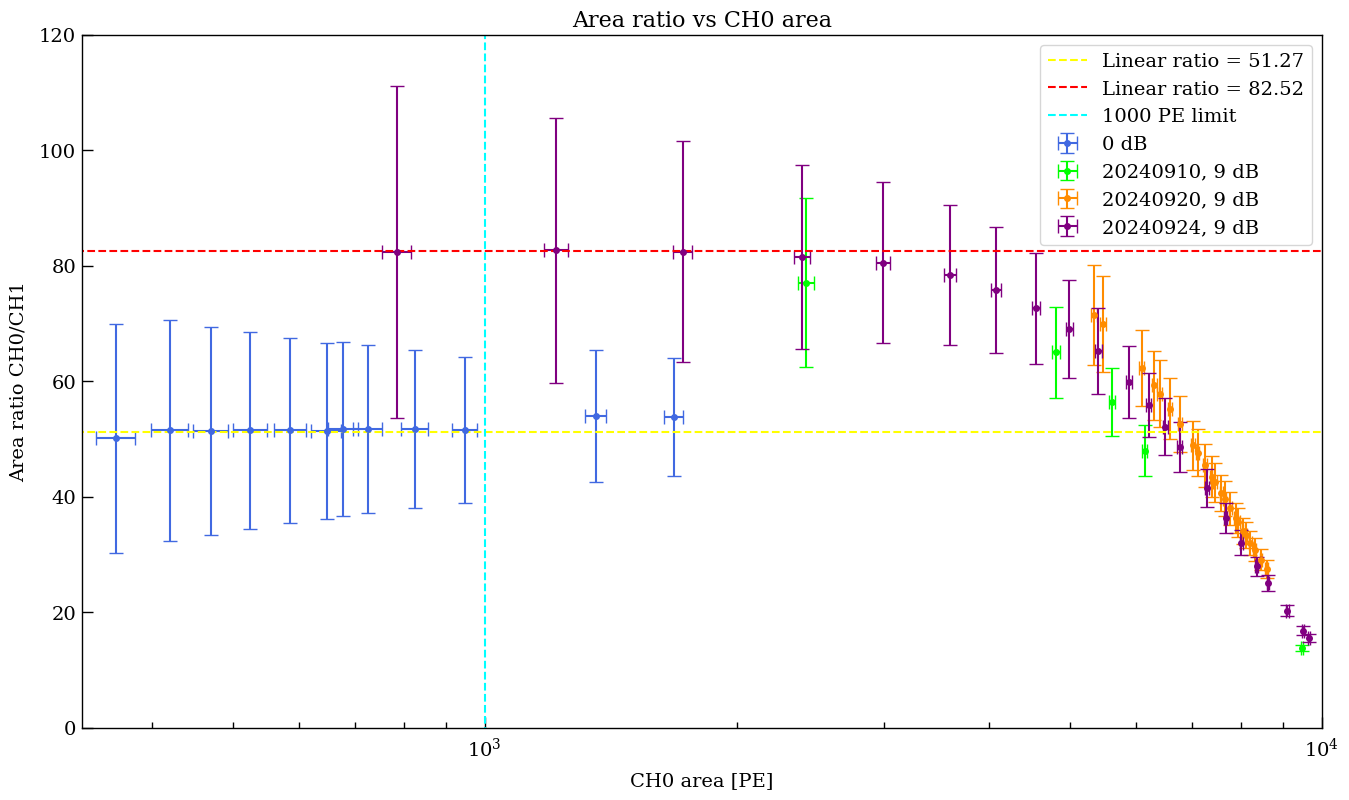

In [94]:
plt.figure(figsize=(16,9))
plt.title('Area ratio vs CH0 area')
plt.xscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Area ratio CH0/CH1')
plt.xlim(330,10000)
plt.ylim(0,120)

plt.errorbar(linear_df['CH0 area'][:20],linear_df['area ratio'][:20],
             xerr=linear_df['CH0 std'][:20],yerr=linear_df['area ratio error'][:20],
             fmt='o',color = 'royalblue',label='0 dB')
plt.errorbar(linear_df[linear_df['date'] == 20240910]['CH0 area'],linear_df[linear_df['date'] == 20240910]['area ratio'],
             xerr=linear_df[linear_df['date'] == 20240910]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240910]['area ratio error'],
             fmt='o',color = 'lime',label='20240910, 9 dB')
plt.errorbar(linear_df[linear_df['date'] == 20240920]['CH0 area'],linear_df[linear_df['date'] == 20240920]['area ratio'],
             xerr=linear_df[linear_df['date'] == 20240920]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240920]['area ratio error'],
             fmt='o',color = 'darkorange',label='20240920, 9 dB')
plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],linear_df[linear_df['date'] == 20240924]['area ratio'],
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240924]['area ratio error'],
             fmt='o',color = 'purple',label='20240924, 9 dB')

plt.hlines(y = 51.27,color = 'yellow',linestyles='dashed',xmin = 0,xmax = 10000,label='Linear ratio = 51.27')
plt.hlines(y = 82.52,color = 'red',linestyles='dashed',xmin = 0,xmax = 10000,label='Linear ratio = 82.52')
plt.vlines(x = 1000,ymin = -50,ymax = 170, color = 'cyan',
           linestyles='dashed',label='1000 PE limit')

plt.legend()
plt.savefig('./img/area_ratio_generalised.png',dpi = 300)
plt.show()

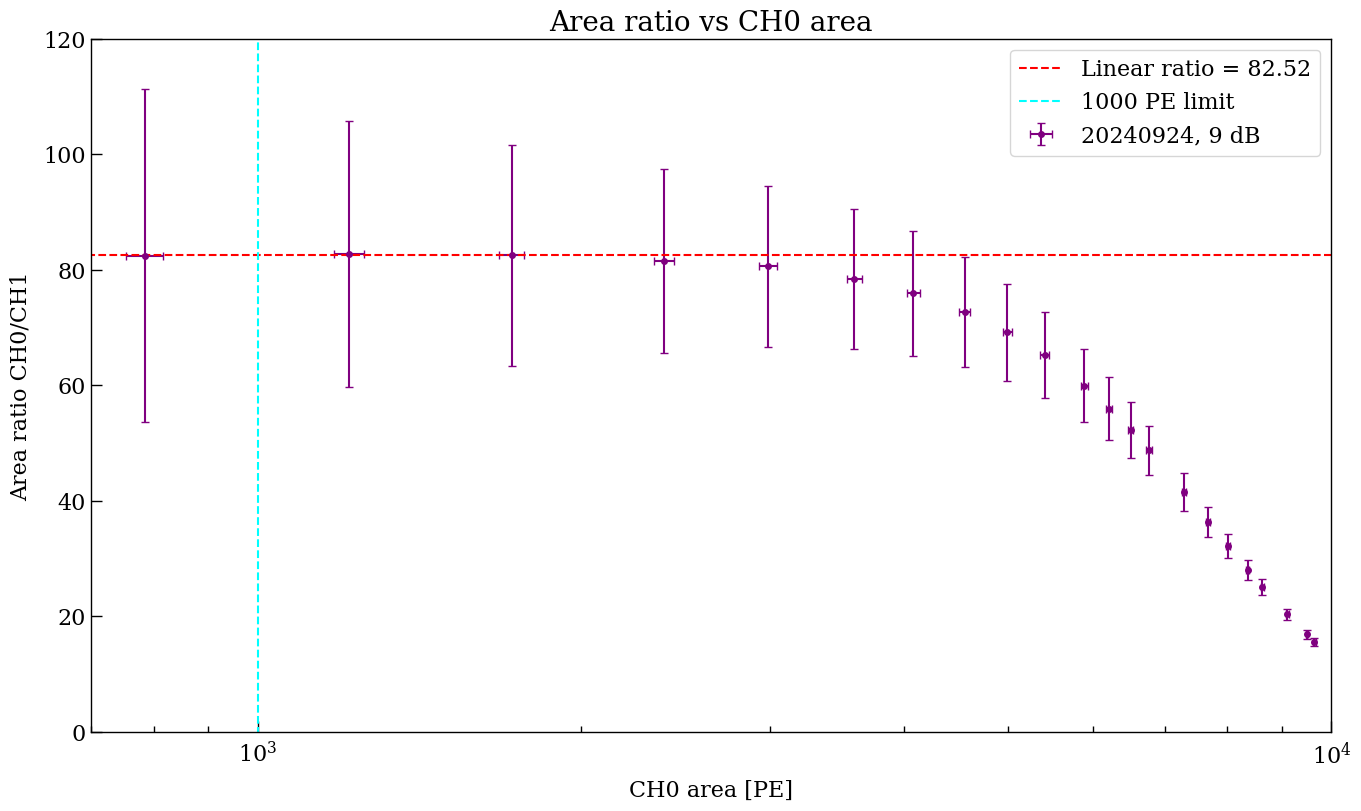

In [21]:
plt.figure(figsize=(16,9))
plt.title('Area ratio vs CH0 area')
plt.xscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Area ratio CH0/CH1')
plt.xlim(700,10000)
plt.ylim(0,120)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],linear_df[linear_df['date'] == 20240924]['area ratio'],
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240924]['area ratio error'],
             fmt='o',color = 'purple',label='20240924, 9 dB',capsize=3)

plt.hlines(y = 82.52,color = 'red',linestyles='dashed',xmin = 0,xmax = 10000,label='Linear ratio = 82.52')
plt.vlines(x = 1000,ymin = -50,ymax = 170, color = 'cyan',
           linestyles='dashed',label='1000 PE limit')

plt.legend()
plt.savefig('./img/area_ratio_generalised_20240924.png',dpi = 300)
plt.show()

### CH1 and CH2 area vs CH0 area

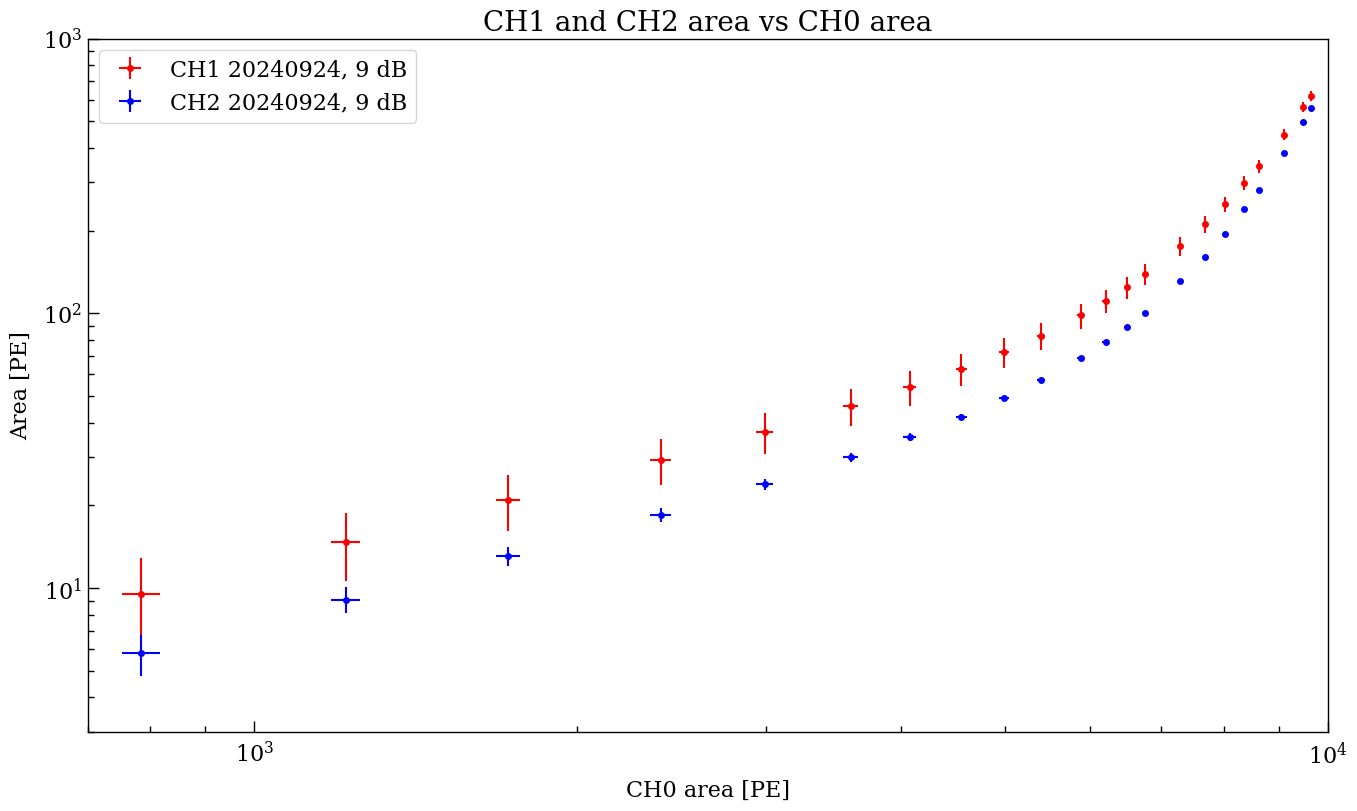

In [31]:
plt.figure(figsize=(16,9))
plt.title('CH1 and CH2 area vs CH0 area')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Area [PE]')
plt.xlim(700,10000)
plt.ylim(3,1000)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],linear_df[linear_df['date'] == 20240924]['CH1 area'],
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240924]['CH1 std'],
             fmt='o',color = 'red',label='CH1 20240924, 9 dB',capsize=0)
plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],linear_df[linear_df['date'] == 20240924]['CH2 area'],
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240924]['CH2 std'],
             fmt='o',color = 'blue',label='CH2 20240924, 9 dB',capsize=0)

plt.legend(loc='upper left')
plt.savefig('./img/ch1_ch0_generalised_20240924.png',dpi = 300)
plt.show()

### Dynode check

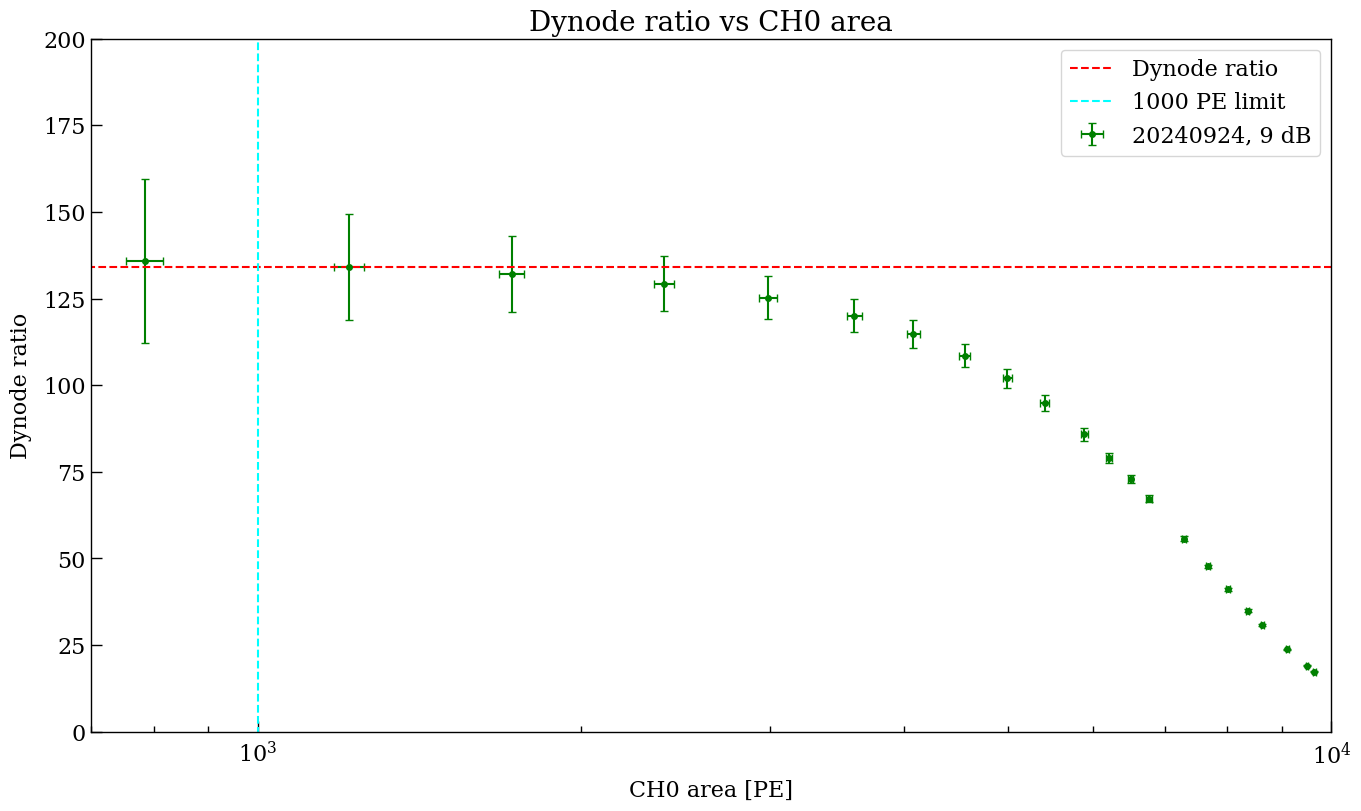

In [15]:
plt.figure(figsize=(16,9))
plt.title('Dynode ratio vs CH0 area')
plt.xscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Dynode ratio')
plt.xlim(700,10000)
plt.ylim(0,200)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],linear_df[linear_df['date'] == 20240924]['dynode ratio'],
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],yerr=linear_df[linear_df['date'] == 20240924]['dynode ratio error'],
             fmt='o',color = 'green',label='20240924, 9 dB',capsize=3)

plt.hlines(y = 133.98,color = 'red',linestyles='dashed',xmin = 0,xmax = 10000,label='Dynode ratio')
plt.vlines(x = 1000,ymin = -50,ymax = 200, color = 'cyan',
           linestyles='dashed',label='1000 PE limit')

plt.legend()
plt.savefig('./img/dynode_ratio_generalised.png',dpi = 300)
plt.show()

### Final

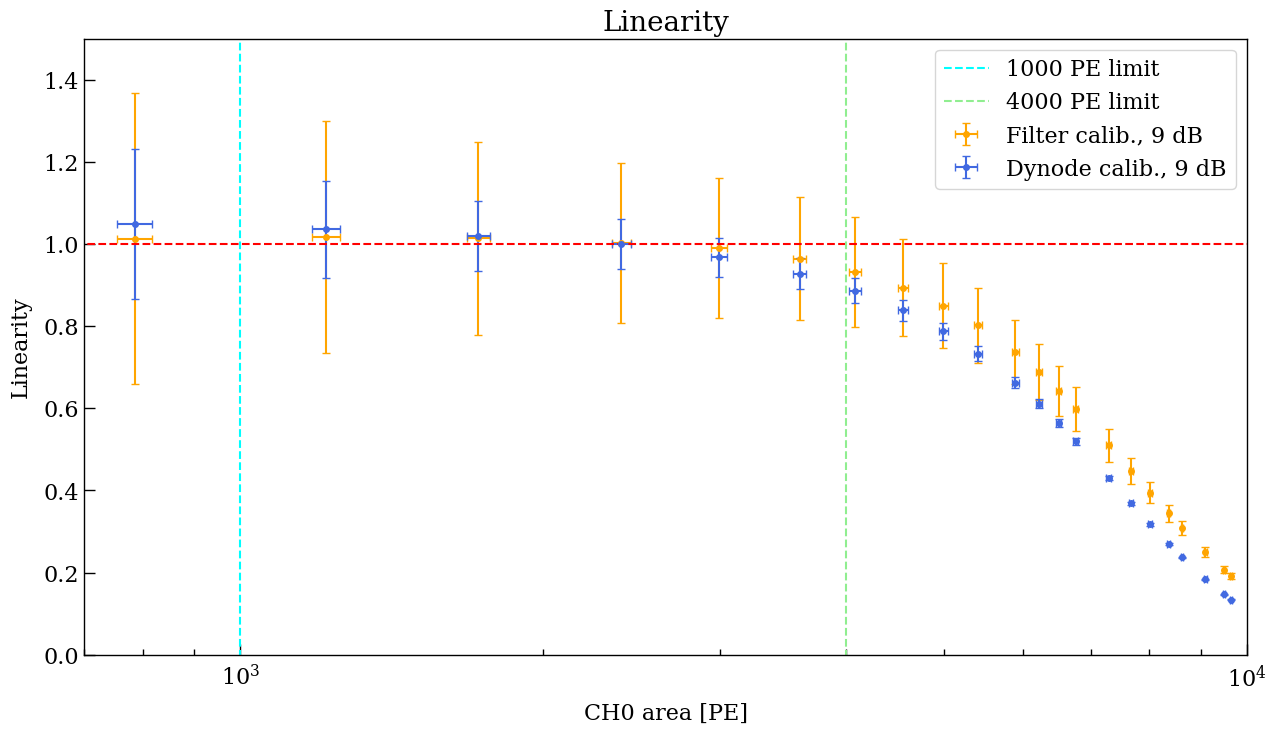

In [46]:
plt.figure(figsize=(15,8))
plt.title('Linearity')
plt.xscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Linearity')
plt.xlim(700,10000)
plt.ylim(0,1.5)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],
             linear_df[linear_df['date'] == 20240924]['area ratio']/area_ratio_filter,
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],
             yerr=linear_df[linear_df['date'] == 20240924]['area ratio error']/area_ratio_filter,
             fmt='o',color = 'orange',label='Filter calib., 9 dB',capsize=3)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],
             linear_df[linear_df['date'] == 20240924]['dynode ratio']/dynode_ratio_filter,
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],
             yerr=linear_df[linear_df['date'] == 20240924]['dynode ratio error']/dynode_ratio_filter,
             fmt='o',color = 'royalblue',label='Dynode calib., 9 dB',capsize=3)

plt.hlines(y = 1,color = 'red',linestyles='dashed',xmin = 0,xmax = 10000)
plt.vlines(x = 1000 ,ymin = -50,ymax = 200, color = 'cyan',
           linestyles='dashed',label='1000 PE limit')
plt.vlines(x = 4000 ,ymin = -50,ymax = 200, color = 'lightgreen',
           linestyles='dashed',label='4000 PE limit')

plt.legend()
plt.savefig('./img/final.png',dpi = 300)
plt.show()

### FFinal

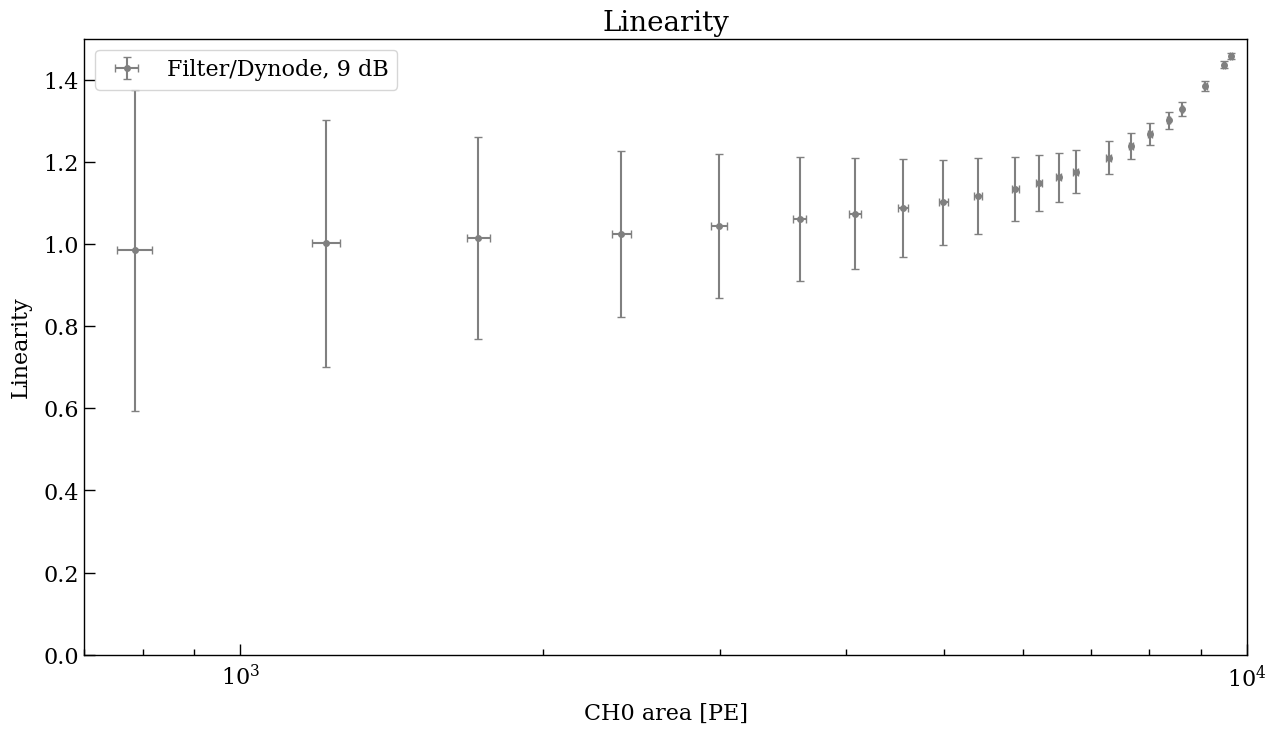

In [29]:
plt.figure(figsize=(15,8))
plt.title('Linearity')
plt.xscale('log')
plt.xlabel('CH0 area [PE]')
plt.ylabel('Linearity')
plt.xlim(700,10000)
plt.ylim(0,1.5)

plt.errorbar(linear_df[linear_df['date'] == 20240924]['CH0 area'],
             (linear_df[linear_df['date'] == 20240924]['area ratio']/82.52)/(linear_df[linear_df['date'] == 20240924]['dynode ratio']/133.98),
             xerr=linear_df[linear_df['date'] == 20240924]['CH0 std'],
             yerr=np.sqrt((linear_df[linear_df['date'] == 20240924]['area ratio error']/82.52)**2 + (linear_df[linear_df['date'] == 20240924]['dynode ratio error']/133.98)**2),
             fmt='o',color = 'grey',label='Filter/Dynode, 9 dB',capsize=3)

plt.legend()
plt.show()